In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install torchaudio
!pip3 install ipdb

    100% |████████████████████████████████| 753.2MB 1.7kB/s eta 0:00:01  9% |███                             | 72.9MB 35.9MB/s eta 0:00:19    11% |███▉                            | 89.6MB 34.8MB/s eta 0:00:20
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 829kB 1.5MB/s eta 0:00:01
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 19.9MB 75kB/s  eta 0:00:01    73% |███████████████████████▋        | 14.7MB 39.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/aims/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
    100% |████████████████████████████████| 6.6MB 221kB/s eta 0:00:01    82% |██████████████████████████▌     | 5.5MB 33.2MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/77/0c/c70f85961ad643801e82276087c8d816ae9

# Part 1: A speech classification training loop, implementing a ConvNet, computing WER

This includes 4 exercises: sections 1.3, 1.4, 1.5, 1.6. This doc can be helpful https://pytorch.org/docs/stable/index.html

## 1.1 Loading the dataset

In [2]:
import torchaudio
import torch
from matplotlib import pyplot as plt
import numpy as np

from torchaudio.datasets import YESNO, LIBRISPEECH
from torch.utils.data import DataLoader

In [3]:
def collate_fn(batch):
    tensors = [b[0].t() for b in batch if b]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)
    
    targets = torch.tensor([b[2] for b in batch if b])
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    
    return tensors, targets

dataset = YESNO(".", download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True,
                                          num_workers=2, collate_fn=collate_fn, drop_last=True)

## 1.2 Features

We are using standard speech features, do not worry about it today, we will come back to it in section 2 of the lab.

In [4]:
# Classic speech rec. features
melfbanks = torchaudio.transforms.MelSpectrogram(n_mels=80)

# The original/standard LibriSpeech SpecAugment policy:
# 80 Mel filters
# 2 frequency masks max 27 frequency bands out of 80
# 2 time masks max 100 timesteps (1 second)
# see https://arxiv.org/abs/1904.08779
timemasking = torchaudio.transforms.TimeMasking(100)
freqmasking = torchaudio.transforms.FrequencyMasking(27)

## 1.3 Model

**Exercise 1:** to start, we are working with the Yes/No dataset, that comprises always "yes" or "no" sequences of length exactly 8. Code a ConvNet based model which takes a variable length input, with 80 features (see above: 1.2 Features) and always output 8 (binary) values.

In [5]:
import ipdb

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# class SimpleConvNet(nn.Module):
#   def __init__(self, kernel_size=3, stride=1, padding=1, depth=5):  ### Those are not good hyperparameters
#     super(SimpleConvNet, self).__init__()
#     ### TODO ###
#     raise NotImplementedError

#   def forward(self, x):
#     ### TODO ###
#     raise NotImplementedError

# model = SimpleConvNet()

class SimpleConvNet(nn.Module):
    def __init__(self, input_dim = 80, kernel_size=3, stride=1, padding=1, depth=5):  ### Those are not good hyperparameters
        super(SimpleConvNet, self).__init__()
        ### TODO ###
        # raise NotImplementedError        
        conv_blocks = []
        
        for i in range(depth-1):
            conv_blocks.append(nn.Sequential(
            nn.Conv1d(input_dim*2**i, input_dim*2**(i+1), kernel_size, stride=stride, padding=padding),          
#             nn.ReLU(inplace=True),
#             nn.MaxPool1d(5, stride = 20)
          ))
            
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.last_conv = nn.Conv1d(nn.ModuleList(conv_blocks)[-1][0].out_channels, 58, kernel_size, stride=20, padding=padding)
        
        self.relu = nn.ReLU(inplace=True)
        self.adaptpool = nn.AdaptiveAvgPool1d(95)
        
        self.maxpool = nn.MaxPool1d(kernel_size)
        
        self.linear1 = nn.Linear(95*58, 180)
        self.linear2 = nn.Linear(180, 8)
        
    def forward(self, x):
        ### TODO ###
        # raise NotImplementedError       
        x = x.squeeze(1)
        
        for layer in self.conv_blocks:
            x = layer(x)        
        
        x = self.last_conv(x)
        x = self.adaptpool(x)
    
        x = self.linear2(self.linear1(x.view(x.shape[0], -1)))
        x = torch.sigmoid(x)
#         x_backward = x
#         ipdb.set_trace()
#         x[x>=0.5] = 1
#         x[x<0.5] = 0
#         x_forward = x
#         y = x_backward + (x_forward - x_backward).detach() 

        # test input
    
        # binary
#         x = torch.sign(x)
#         x = torch.relu(x)
        
        return x

model = SimpleConvNet(input_dim = 80, kernel_size=5, stride=2, padding=1, depth=4)

## 1.4 Visualize features and network output

**Exercise 2:** visualize the input waveform, the MelSpectrogram features before and after data augmentation with SpecAugment, and the model's output (you could for instance use plt.plot, plt.imshow, plt.bar). Use this to debug your model's forward.

<class 'torch.Tensor'> torch.Size([16, 1, 55840])
<class 'torch.Tensor'> torch.Size([16, 8])


<Figure size 432x288 with 0 Axes>

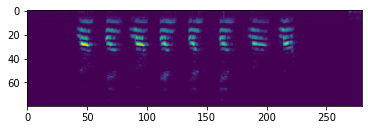

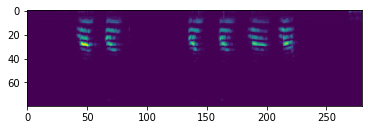

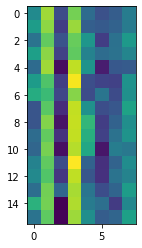

In [7]:
from matplotlib import pyplot as plt
x, y = next(iter(data_loader))
print(type(x), x.shape)
print(type(y), y.shape)
plt.figure()
### TODO: visualize the waveform input
x = torch.log(1. + melfbanks(x))  # Those are the speech features we can train on
plt.figure()
plt.imshow(x[0, :].squeeze())
plt.show()

### TODO: visualize input features
x = timemasking(freqmasking(x))  # Those are the speech featues with some data augmentation (SpecAugment) applied, better to train on that to avoid overfitting
plt.figure()
plt.imshow(x[0,:].squeeze())
plt.show()

### TODO: visualize SpecAugment
x = model.to("cpu")(x)
plt.figure()

### TODO: visualize the model's output
plt.imshow(x.squeeze().detach().numpy())
plt.show()

## 1.5 Training loop including loss and model updates

**Exercise 3:** implement a training loop with your previously defined model (fix it if necessary). Here we don't have a validation nor a test set, so the task is to overfit the train set (bring the training loss to almost 0). Then try SpecAugment.
Hint: I got it to work with BCE, MSE and MultiLabel losses. If you can't overfit the train set, change your model from 1.3.

BONUS: you can add other data augmentations from https://pytorch.org/audio/transforms.html

In [8]:
import torch.optim as optim

N_EPOCHS = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNet().to(device)

### TODO hyperparams ###
criterion = nn.MSELoss()  ### TODO ###
optimizer = optim.Adam(model.parameters(), lr=6e-5)  ### TODO ###

running_loss = 0.0
i = 0

        
for epoch in range(N_EPOCHS):
    for x, y in data_loader:
        ### TODO compute the speech features (example in 1.4) ###
        x = torch.log(1. + melfbanks(x))
#         x = timemasking(freqmasking(x))
    
        x, y = x.to(device), y.to(device)
        ### TODO train the model ###
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)

        loss = criterion(outputs, y.float())
    
        loss.backward()
        optimizer.step()

        i += 1
        running_loss += loss.item()
        if i % 20 == 0:
            print("loss: %.8f" % (running_loss / 20))
            running_loss = 0.0

loss: 0.24055622
loss: 0.19511548
loss: 0.12280513
loss: 0.06355109
loss: 0.03132149
loss: 0.03924039
loss: 0.03134638
loss: 0.01414407
loss: 0.01689245
loss: 0.02459084
loss: 0.01682477
loss: 0.01488106
loss: 0.01236808
loss: 0.00878950
loss: 0.01318672


## 1.6 Implementing WER

In [9]:
!pip install jiwer

  Using cached python-Levenshtein-0.12.0.tar.gz (48 kB)
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp37-cp37m-linux_x86_64.whl size=160824 sha256=9ffd49397d9bccd2975f4bbdd74d5ee554a20650a6fa8f476fca120d6105d1ca
  Stored in directory: /home/aims/.cache/pip/wheels/f0/9b/13/49c281164c37be18343230d3cd0fca29efb23a493351db0009
Successfully built python-Levenshtein


**Exercise 4:** implement WER and compare to jiwer.

In [10]:
from jiwer import wer
import re
import numpy as np

punctuation = re.compile('[,.?!:;"]')

ground_truth =  punctuation.sub("", "I like monthy python, and AMMI is awesome")
hypothesis =  punctuation.sub("", "I like python, what is AMMI? it is awesome")

def mywer(g, h):  # gold, hypothesis
    # dynamic programming algorithm that returns
    # (substitutions + deletions + insertions) / ground_truth_nb_words
    ### TODO initialize
    g = g.split()
    h = h.split()
    
    d = np.zeros([len(g)+1,len(h)+1])
    d[:,0] = np.arange(0, len(g)+1)
    d[0,:] = np.arange(0, len(h)+1)
    
    ### TODO compute the alignment
    for j in range(1,len(h)+1):
        for i in range(1,len(g)+1):
            if g[i-1] == h[j-1]:
                d[i,j] = d[i-1,j-1]+0
            else:
                replacement = d[i-1,j-1]+1
                insertion = d[i,j-1]+1
                delection = d[i-1,j]+1
                
                d[i,j] = min(delection, insertion, replacement)
        
    return d[-1,-1]/len(g)

assert mywer(ground_truth, hypothesis) == wer(ground_truth, hypothesis)
print(mywer(ground_truth, hypothesis), wer(ground_truth, hypothesis))

ModuleNotFoundError: No module named 'jiwer'

# Part 2: implementing speech features

May be helpful:
https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
and https://librosa.github.io/librosa/index.html and ![alt text](https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1853261/preview.jpg)

## 2.1 spectrogram

In [11]:
import IPython
IPython.display.Audio("waves_yesno/0_1_0_1_1_0_1_0.wav", rate=16000)

**Exercise 1:** using https://numpy.org/doc/stable/reference/generated/numpy.hanning.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html compute the spectrogram of the waveform (short-time Fourier transforms) with window size 25ms and stride 10ms, and 256 frequencies. Plot and compare your spectrogram to `torchaudio.transforms.Spectrogram()` on one file from YESNO (see 1.4). **They will probably not match exactly in values** as it depends of a lot of pre- and post-processing of the signal, but what matters is that the plots look similar.

<class 'torch.Tensor'> torch.Size([16, 1, 52800])
<class 'torch.Tensor'> torch.Size([16, 8])


/home/aims/anaconda3/envs/aims/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/aims/anaconda3/envs/aims/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


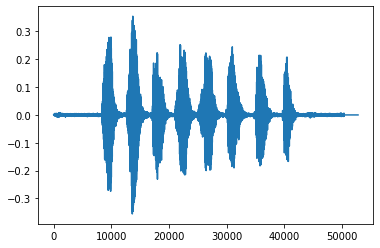

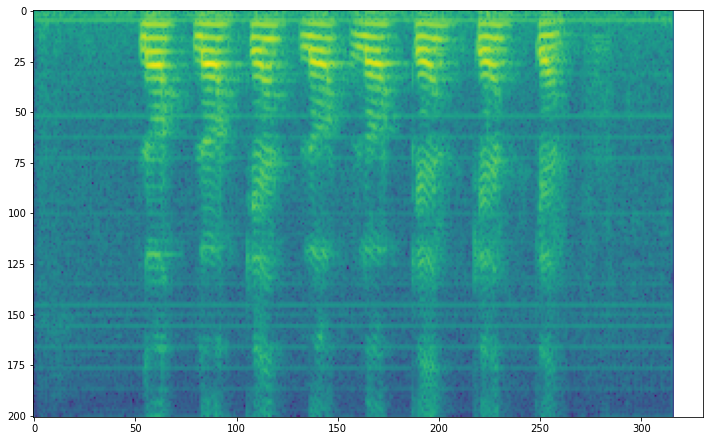

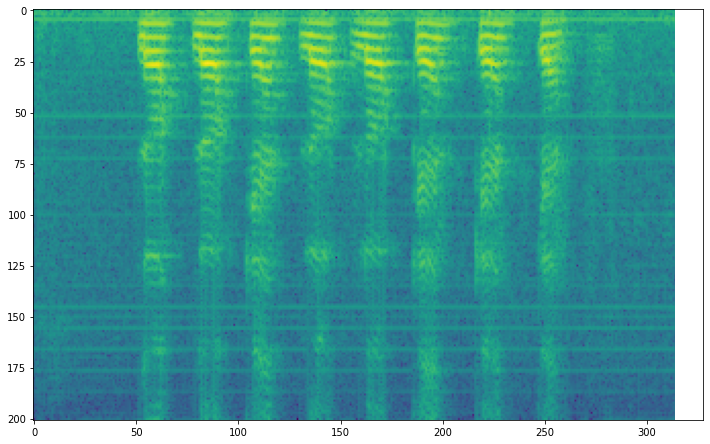

In [12]:
from matplotlib import pyplot as plt
import numpy as np

x, y = next(iter(data_loader))
print(type(x), x.shape)
print(type(y), y.shape)
plt.figure()

# visualize waveform
plt.plot(x[0,0])
plt.figure(figsize=(12,8))

# visualize torchaudio spectrogram
torchaudiospectro = torchaudio.transforms.Spectrogram(n_fft=400, win_length=400, hop_length=160)(x)
plt.imshow(np.log(torchaudiospectro[0,0]))
plt.figure(figsize=(12,8))

# create my spectrogram
from numpy.lib.stride_tricks import as_strided
WSIZE_SEC = 0.025
WSTRIDE_SEC = 0.01
FS = 16000
NFFT = 400

WSIZE = int(FS * WSIZE_SEC) # TODO, 400
WSTRIDE = int(FS * WSTRIDE_SEC) # TODO, 160
WINDOW = np.hamming(WSIZE)[:, None] # TODO

def myspectrogram(inp):
    s = inp
    # TODO
    
    s = inp[:len(inp) - (len(inp) - NFFT) % WSTRIDE]
    shape = (NFFT, (len(s) - NFFT) // WSTRIDE + 1)
    strides = (s.strides[0], s.strides[0] * WSTRIDE)
    s = as_strided(s, shape=shape, strides=strides)
    s = np.fft.rfft(s * WINDOW, axis=0) # Formula in slide 35
    s = (np.absolute(s)**2).transpose() # I included transpose to make the pictures similar to torchaudio
    
    return s / np.sqrt((WINDOW ** 2).sum())


# # visualize my spectrogram
myspectro = np.log(myspectrogram(x[0,0].numpy().astype(np.double))).transpose()

plt.imshow(myspectro)

## 2.2 Mel scale

**Exercise 2 (OPTIONAL, difficult):** implement a Mel scale, compare it to `torchaudio`'s. Compare (with plots and a file) your Mel spectrogram to `torchaudio`'s. Feel free to use Hertz to Mel: $2595 \log_{10}(1 + f/700)$, and remember that filterbanks are triangular, maximum at the center frequency and linear to 0 at the center frequency of the above and below filter.

/home/aims/anaconda3/envs/aims/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


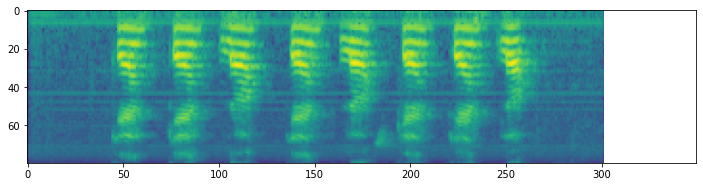

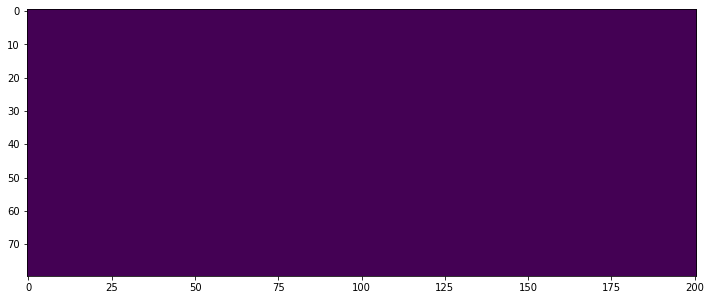

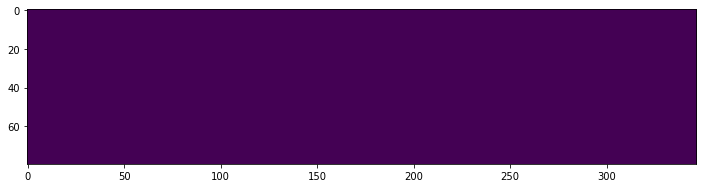

In [13]:
x, y = next(iter(data_loader))

NMELS = 80

myspectro = myspectrogram(x[0,0].numpy().astype(np.double)).transpose()

# visualize torchaudio log Melspectrogram
plt.figure(figsize=(12,8))
torchaudiomelspectro = torchaudio.transforms.MelSpectrogram(n_fft=400, win_length=400, hop_length=160, n_mels=NMELS)(x)
plt.imshow(np.log(torchaudiomelspectro[0,0]))

# visualize my Mel scale
plt.figure(figsize=(12,8))
mymelscale = np.zeros((NFFT//2+1, NMELS), dtype=np.double)

def hertz_to_mel(freq):
    raise NotImplementedError

def mel_to_hertz(mel):
    raise NotImplementedError

# TODO complete your Mel scale (you need to do something like mel_to_hertz(np.linspace(hertz_to_mel(100), hertz_to_mel(8000), TODO)))

plt.imshow(mymelscale.transpose())

# visualize my Melspectrogram PROBABLY QUITE FAR OFF (lots of pre/post processing gain/filters for torchaudio's)
plt.figure(figsize=(12,8))
mymelspectro = np.dot(myspectro.transpose(), mymelscale).clip(1.0e-8, 1.0e8)
plt.imshow(mymelspectro.transpose())


## 2.3 putting it together

**Exercise 3 (OPTIONAL):** redo the training loop from the first lab (1.5), with your log compressed Melspectrogram if you did 2.2, or with powerspectrum if you only did 2.1, as input features.

In [ ]:
# TODO (copy from your working 1.5 to get started)

## 2.4 wav-based acoustic model

**Exercice 4:** remove the log Mel filterbanks features in your training loop (section 1.5) and add one convolution (in 1.3) at the very beginnning of the model, that outputs **at the same striding and over the same windows as the Mel filterbanks feature do**. Visualize what you learned for this convolution at the end of training. Hint: you may need to train a bit longer or with a slightly different learning rate than you did in the past.

BONUS: SpecAugment is the same in time, but the frequency masking becomes a [band-stop filter](https://en.wikipedia.org/wiki/Band-stop_filter), you can implement it with scipy/numpy.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleConvNetWav(nn.Module):
    def __init__(self, input_dim = 80, kernel_size=3, stride=1, padding=1, depth=5):
        super(SimpleConvNetWav, self).__init__()
        # TODO
        
        conv_blocks = []
        
        self.first_conv = nn.Conv1d(1, input_dim, kernel_size, stride=220, padding=padding)

        for i in range(depth-1):
            conv_blocks.append(nn.Sequential(
            nn.Conv1d(input_dim*2**i, input_dim*2**(i+1), kernel_size, stride=stride, padding=padding),          
#             nn.ReLU(inplace=True),
#             nn.MaxPool1d(5, stride = 20)
          ))
            
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.last_conv = nn.Conv1d(nn.ModuleList(conv_blocks)[-1][0].out_channels, 58, kernel_size, stride=20, padding=padding)
        
        self.relu = nn.ReLU(inplace=True)
        self.adaptpool = nn.AdaptiveAvgPool1d(200)
        
        self.maxpool = nn.MaxPool1d(kernel_size)
        
        self.linear1 = nn.Linear(200*58, 180)
        self.linear2 = nn.Linear(180, 8)
        
    def forward(self, x):
        # TODO
#         ipdb.set_trace()
        x = self.first_conv(x)
        
        for layer in self.conv_blocks:
            x = layer(x)        
        
        x = self.last_conv(x)
        x = self.adaptpool(x)
    
        x = self.linear2(self.linear1(x.view(x.shape[0], -1)))
        x = torch.sigmoid(x)
        
        return x

N_EPOCHS = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNetWav(input_dim = 80, kernel_size=3, 
                stride=3, padding=1, depth=5).to(device)  # TODO change hyperparams of SimpleConvNetWav

criterion = nn.MSELoss()  # TODO
# optimizer = optim.SGD(model.parameters(), lr=0.58)#, momentum=0.9)  # TODO
optimizer = optim.Adam(model.parameters(), lr=6e-5)  ### TODO ###

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y.float())
        loss.backward()
        optimizer.step()
        i += 1

        running_loss += loss.item()
        if i % 20 == 0:
            print("loss: %.8f" % (running_loss / 20))
            running_loss = 0.0

In [ ]:
x, y = next(iter(data_loader))
x, y = x.to(device), y.to(device)
print(type(x), x.shape)
print(type(y), y.shape)
plt.figure(figsize=(10, 10))
### TODO: visualize the waveform input
x = model.first_conv(x)  # Those are the speech features we can train on
plt.figure()
plt.imshow(x[0].detach().cpu().squeeze())
plt.show()

## 2.5 OPTIONAL: LibriSpeech 100h

If you are patient enough (the training will take many hours even with a small model) you can redo any of the previous training loops on 100h of read English speech, LibriSpeech train-clean-100. And now, you have a dev and test set! (So you can do proper machine learning!) If you do direct classification you could use words as targets, if you're using CTC, you can use letters. **Tip:** if you want to "debug by overfitting", _train_ on the dev (validation) set only.

In [36]:
import os
from typing import Tuple

import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio.datasets.utils import (
  download_url,
  extract_archive,
  walk_files,
)

URL = "train-clean-100"
FOLDER_IN_ARCHIVE = "LibriSpeech"
BASE_URL = "https://dl.fbaipublicfiles.com/librispeech_100h_mp3/"
_CHECKSUMS = {
  BASE_URL + "dev-clean.tar.gz":
  "076916a8f9c61951c5d2e6efaa8d2188232fcf860eec8c074e46edf4fac9623e",
  BASE_URL + "test-clean.tar.gz":
  "3c171e2f1e377e4993c2dbe6bff3f01cd324c0ed462f4de6c78737402a7dbedd",
  BASE_URL + "train-clean-100.tar.gz":
  "7bfbefc680d25ba3a82798ce32c287ea0e82932af1b1f864fae71fb52d2f41f0",
}


def load_librispeech_item(fileid: str, 
                          path: str, 
                          ext_audio: str, 
                          ext_txt: str) -> Tuple[Tensor, int, str, int, int, int]:
    speaker_id, chapter_id, utterance_id = fileid.split("-")
    
    file_text = speaker_id + "-" + chapter_id + ext_txt
    file_text = os.path.join(path, speaker_id, chapter_id, file_text)
    
    fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
    file_audio = fileid_audio + ext_audio
    file_audio = os.path.join(path, speaker_id, chapter_id, file_audio)
    
    # Load audio
    waveform, sample_rate = torchaudio.load(file_audio)
    
    # Load text
    with open(file_text) as ft:
        for line in ft:
            fileid_text, utterance = line.strip().split(" ", 1)
            if fileid_audio == fileid_text:
                break
        else:
          # Translation not found
          raise FileNotFoundError("Translation not found for " + fileid_audio)
            
#     ipdb.set_trace()
    
    return (
        waveform,
        sample_rate,
        utterance,
        int(speaker_id),
        int(chapter_id),
        int(utterance_id)
        )


class LIBRISPEECH_100H_MP3(Dataset):
    """
    Create a Dataset for LibriSpeech. Each item is a tuple of the form:
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id
    """
    
    _ext_txt = ".trans.txt"
    _ext_audio = ".mp3"
    
    def __init__(self,
                 root: str,
                 url: str = URL,
                 folder_in_archive: str = FOLDER_IN_ARCHIVE,
                 download: bool = False) -> None:
        if url in [
            "dev-clean",
            "test-clean",
            "train-clean-100",]:
            ext_archive = ".tar.gz"
            base_url = BASE_URL
            url = os.path.join(base_url, url + ext_archive)

        basename = os.path.basename(url)
        archive = os.path.join(root, basename)

        basename = basename.split(".")[0]
        folder_in_archive = os.path.join(folder_in_archive, basename)

        self._path = os.path.join(root, folder_in_archive)
        
#         if download:
#             if not os.path.isdir(self._path):
#                 if not os.path.isfile(archive):
#                     checksum = _CHECKSUMS.get(url, None)
#                     download_url(url, root, hash_value=checksum)
#                 extract_archive(archive)

        walker = walk_files(
          self._path, suffix=self._ext_audio, prefix=False, remove_suffix=True
        )
        
        self._walker = list(walker)
        ipdb.set_trace()
    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, int, int, int]:
        fileid = self._walker[n]
#         ipdb.set_trace()
        return load_librispeech_item(fileid, self._path, self._ext_audio, self._ext_txt)
    
    def __len__(self) -> int:
        return len(self._walker)

Now you have access to a training set, but also a validation set ("dev" for development) to perform early stopping and hyperparams optimization on (you can look at it e.g. every epoch), and finally a test set (on which you should look at the performance only at the very end, after having completed training).

In [52]:
!rm -r LibriSpeech

In [55]:
# big_data/2020-AMMI-salomon/notebooks/MT-ASR/LibriSpeech/dev-clean
libri_dev = LIBRISPEECH_100H_MP3("../", url="dev-clean", download=True)

--Return--
None
> <ipython-input-36-88b9089e442e>(106)__init__()
    105         self._walker = list(walker)
--> 106         ipdb.set_trace()
    107     def __getitem__(self, n: int) -> Tuple[Tensor, int, str, int, int, int]:



ipdb>  len(self._walker)


2703


ipdb>  q


BdbQuit: 

In [33]:
# just so you get an idea of the format 
print(next(iter(libri_dev)))
# libri_dev = LIBRISPEECH_100H_MP3(".", url="dev-clean", download=True)

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0054, -0.0054, -0.0056]]), 16000, 'MODE LET THE TARTARIC ACID AND SALT BE REDUCED TO THE FINEST POSSIBLE POWDER THEN MIX THEM WELL WITH THE FLOUR', 2078, 142845, 20)


In [ ]:
'2078-142845-0020'


In [9]:
# bigger download, shouuld take 2-3 minutes on Colab
libri_train = LIBRISPEECH_100H_MP3(".", url="train-clean-100", download=True)
libri_test = LIBRISPEECH_100H_MP3(".", url="test-clean", download=True)

In [10]:
# Only use this if your acoustic model outputting words directly
#lexicon = set()
#for utterance in libri_train:  # TODO use parallel Pool.map() and reduce the sets
#  lexicon.update(utterance[2].split())
#print("Lexicon's size: {}".format(len(lexicon)))

In [11]:
# Use this is your acoustic model is outputting letters
tokens_list = list(" ABCDEFGHIJKLMNOPQRSTUVWXYZ")
tokens_set = set(tokens_list)
print(tokens_list)

[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [12]:
def collate_fn_libri(batch):
    #print(batch)
    tensors = [b[0].t() for b in batch if b]
    tensors_len = [len(t) for t in tensors]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)
    
    transcriptions = [list(b[2].replace("'", " ")) for b in batch if b]
    targets = [torch.tensor([tokens_list.index(e) for e in t]) for t in transcriptions]
    targets_len = [len(t) for t in targets]
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    
    return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

train_set = torch.utils.data.DataLoader(libri_train, batch_size=2, shuffle=True,
                                        num_workers=4, collate_fn=collate_fn_libri)

In [13]:
print(next(iter(train_set)))
train_set = torch.utils.data.DataLoader(libri_train, batch_size=16, shuffle=True,
                                        num_workers=2, collate_fn=collate_fn_libri)

(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.4779e-03,
           1.3205e-03, -4.2398e-05]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]]), tensor([[20,  8,  1, 20,  0, 23,  5,  0,  8,  1, 22,  5,  0,  2,  5,  5, 14,  0,
          4,  9, 19,  3, 21, 19, 19,  9, 14,  7,  0, 10, 21, 19, 20,  0,  1, 19,
          0,  1,  0,  6,  9,  5, 12,  4,  0,  9, 19,  0,  4, 18,  1,  9, 14,  5,
          4,  0, 16, 12, 15, 23,  5,  4,  0,  1, 14,  4,  0,  3, 21, 12, 20,  9,
         22,  1, 20,  5,  4,  0, 20, 15,  0,  6,  9, 20,  0,  9, 20,  0,  2,  5,
         20, 20,  5, 18,  0, 20, 15,  0, 25,  9,  5, 12,  4,  0,  1,  0,  3, 18,
         15, 16,  0, 19, 15,  0,  9, 19,  0, 20,  8,  5,  0,  9, 18, 15, 14,  0,
         15, 18,  5,  0, 19,  8,  1, 16,  5,  4,  0,  9, 14, 20, 15,  0,  1,  0,
          6, 15, 18, 13],
        [ 5,  1, 18, 12,  9,  5, 18,  0, 20,  9, 13,  5, 19,  0, 19, 21, 18,  5,
         12, 25,  0, 13,  1, 

In [14]:
data_loader = train_set

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleConvNetWav(nn.Module):
    def __init__(self, input_dim = 80, kernel_size=3, stride=1, padding=1, depth=5):
        super(SimpleConvNetWav, self).__init__()
        # TODO
        
        conv_blocks = []
        
        self.first_conv = nn.Conv1d(1, input_dim, kernel_size, stride=stride, padding=padding)

        for i in range(depth-1):
            conv_blocks.append(nn.Sequential(
            nn.Conv1d(input_dim*2**i, input_dim*2**(i+1), kernel_size, stride=stride, padding=padding),          
#             nn.ReLU(inplace=True),
#             nn.MaxPool1d(5, stride = 20)
          ))
            
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.last_conv = nn.Conv1d(nn.ModuleList(conv_blocks)[-1][0].out_channels, 58, kernel_size, stride=20, padding=padding)
        
        self.relu = nn.ReLU(inplace=True)
        self.adaptpool = nn.AdaptiveAvgPool1d(200)
        
        self.maxpool = nn.MaxPool1d(kernel_size)
        
        self.linear1 = nn.Linear(200*58, 180)
        self.linear2 = nn.Linear(180, 8)
        
    def forward(self, x):
        # TODO
#         ipdb.set_trace()
        x = self.first_conv(x)
        
        for layer in self.conv_blocks:
            x = layer(x)        
        
        x = self.last_conv(x)
        x = self.adaptpool(x)
    
        x = self.linear2(self.linear1(x.view(x.shape[0], -1)))
        x = torch.sigmoid(x)
        
        return x

N_EPOCHS = 190

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNetWav(input_dim = 80, kernel_size=8, 
                stride=3, padding=1, depth=5).to(device)  # TODO change hyperparams of SimpleConvNetWav

criterion = nn.MSELoss()  # TODO
optimizer = optim.SGD(model.parameters(), lr=0.58)#, momentum=0.9)  # TODO
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # TODO

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
    for x, y, tensors_len, targets_len in data_loader:
        ipdb.set_trace()
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y.float())
        loss.backward()
        optimizer.step()
        i += 1

        running_loss += loss.item()
        if i % 20 == 0:
            print("loss: %.8f" % (running_loss / 20))
            running_loss = 0.0

# Part 3 End-to-end training

## 3.1 Train with CTC (using PyTorch's implementation)

**Exercise 1:** Train your `SimpleConvNet` with [`nn.CTCLoss`](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). Very hard to get it to converge (on Colab...), but the loss should be going down! That should be your criterion for success. If you're bored of YESNO, you can try LibriSpeech, the simplest is probably to train on the validation set (dev). I included some helper function for that with `collate_fn_libri` but feel free to roll your own.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

N_EPOCHS = 500
BATCH_SIZE = 32


def collate_fn_yesno(batch):
    tensors = [b[0].t() for b in batch if b]
    tensors_len = [len(t) for t in tensors]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)
    
    targets = torch.tensor([b[2] for b in batch if b]) + 1  # you can do it differently than the +1 if you want (it's to add room for the blank label at index 0)
    targets_len = [len(t) for t in targets]
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    
    return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)


yesno_dataset = YESNO(".", download=True)


### EXPERIMENTAL ###
MAX_X_LEN = 100  # limiting the length of the utterances, play with those
MAX_Y_LEN = 10   # limiting the length of the utterances, play with those
def collate_fn_libri(batch):
    tensors = [b[0][:MAX_X_LEN].t() for b in batch if b]
    tensors_len = [len(t) for t in tensors]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)
    
    transcriptions = [list(b[2].replace("'", " ")) for b in batch if b]
    targets = [torch.tensor([tokens_list.index(e) for e in t][:MAX_Y_LEN]) for t in transcriptions]
    targets_len = [len(t) for t in targets]
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    
    return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

dev_set = torch.utils.data.DataLoader(libri_dev, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=4, collate_fn=collate_fn_libri)  # yes, train on the dev set, to debug you model
### /EXPERIMENTAL ###


class SimpleConvNetCTC(nn.Module):
    def __init__(self, kernel_size=3, padding=1, stride=1, depth=5):
        super(SimpleConvNetCTC, self).__init__()
        ### TODO complete
        self.depth = depth
        self.conv = nn.Conv1d(80, 80, kernel_size, stride, padding)
        self.conv_net = nn.ModuleList([copy.deepcopy(self.conv) for _ in range(self.depth)])
        self.maxpool = nn.AdaptiveMaxPool1d(7)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=-1)
        self.conv2 = nn.Conv1d(80, 32, kernel_size=3, stride=2)
        
    def forward(self, x):
        ### TODO complete
        x = x.squeeze()
        for layer in range(self.depth):
            x = self.relu(self.conv_net[layer](x))
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.log_softmax(x)
        x = x.permute(1, 0, 2)    
        return x


data_loader = torch.utils.data.DataLoader(yesno_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                          num_workers=2, collate_fn=collate_fn_yesno)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = SimpleConvNetCTC(kernel_size=5, padding=2, depth=7).to(device)

hyperparams = {"kernel_size":3, "stride":1, "padding":1, "depth":7}
model = SimpleConvNetCTC(**hyperparams).to(device)

criterion = nn.CTCLoss(zero_infinity=True)
optimizer = optim.SGD(model.parameters(), lr=0.58)  ### TODO

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
    for x, y, x_len, y_len, in data_loader:  
        x_batch_len = x.shape[-1]
        x = torch.log(1. + melfbanks(x))
        x = x.squeeze()
        x, y = x.to(device), y.to(device)
                
        optimizer.zero_grad()
        yhat = model(x)
        yhat_len = torch.tensor([int(yhat.shape[0]*x_len[i]/x_batch_len) for i in range(yhat.shape[1])]) # this is an approximation, should be good enough
#         ipdb.set_trace()
        loss = criterion(yhat, y.float(), yhat_len, y_len)  ### TODO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        i += 1

        running_loss += loss.item()
        if i % 100 == 0:
            print("loss: %.8f" % (running_loss / 20))
            running_loss = 0.0
            #print(yhat[0])
            #print(y[0])

loss: 6.44088598
loss: 5.03006312
loss: 3.54733377
loss: 3.09983093


KeyboardInterrupt: 

## 3.2 Implementing CTC

**Exercise 2 (difficult):** Implement your own CTC loss `myCTC`, pass the assert here. Note that the predictions are in log probabilities, not in probabilities. https://distill.pub/2017/ctc/ may be helpful.

In [ ]:
#y = [1, 2] # simpler, for debug
#p = torch.rand(3, 3) # simpler for debug

y = [1, 2, 3]  # e.g. it's "cat"
p = torch.rand((4, 5))  # 5 classes because we add one other letter for fun + blank (ø, index 0)
p = F.log_softmax(p, dim=1)

criterion = nn.CTCLoss()
inp_len = torch.tensor([p.shape[0]]).unsqueeze(1)
tar_len = torch.tensor([len(y)]).unsqueeze(1)
p = p.unsqueeze(1)
print(p, p.shape)
y = torch.tensor(y).unsqueeze(0)
l = criterion(p, y, inp_len, tar_len)
print(l)

def myCTC(p, y, il, tl):
    """Returns the CTC loss of p (log probs) to y (targets) with blank label 0"""
    cache = [[None for _ in range(il.squeeze())] for _ in range(tl.squeeze())]  # cache[target][source]
    ### TODO complete this
    raise NotImplementedError
    return -1

assert torch.allclose(l, myCTC(p, y, inp_len, tar_len))

## 3.3 Implementing Beam Search

**Exercise 3 (optional, difficult):** implement (vanilla) beam search, test it on the previous (`y` and `p`) example form 3.2. How can you deal with the blanks? The answer is in https://distill.pub/2017/ctc/